In [11]:
import pandas as pd 
import numpy as np 
from collections import Counter
import xgboost
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import time
import warnings
import sklearn
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score
import datetime
%matplotlib inline
warnings.filterwarnings('ignore')

#file=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/matrix_0.csv'
file=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/cleaned_matrix.xlsx'
weatherfile=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/weather_data_2014-1-1~2016~9-30.xlsx'
holidayfile=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/holidays.xlsx'
if_rainfile=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/if_rain.xlsx'
numst='sum'

data=pd.read_excel(file)
weatherdata=pd.read_excel(weatherfile)
holidaydata=pd.read_excel(holidayfile,header=None)
data=data.set_index('Unnamed: 0')
k=[str(x) for x in range(1,1367)]
k.append('sum')
data.columns=k
weatherdata=weatherdata.set_index('date')
if_raindata=pd.read_excel(if_rainfile)


def tz(df,str1):
    df['timestamp']=df.index
    df['time_stamp']=pd.DataFrame(pd.to_datetime(df['timestamp']))
    df['dow'] = df.time_stamp.apply(lambda x: x.dayofweek)
    df['doy'] = df.time_stamp.apply(lambda x: x.dayofyear)
    df['day'] = df.time_stamp.apply(lambda x: x.day)
    df['is_weekend']=df.time_stamp.apply(lambda x:1 if x.dayofweek in range(5,7) else 0)
    df['month'] = df.time_stamp.apply(lambda x: x.month)
    df['d-1']=df[str1].shift(1)
    df['d-2']=df[str1].shift(2)
    df['d-3']=df[str1].shift(3)
    df['d-4']=df[str1].shift(4)
    df['d_dif']=df['d-1']-df['d-2']
    weatherdata['date']=weatherdata.index
    combineddf=pd.merge(left=df,right=weatherdata,left_on='time_stamp',right_on='date',how='left')
    combineddf=combineddf.fillna(method='bfill')
    return combineddf

combineddf=tz(pd.DataFrame(data[numst]),numst)
combineddf=combineddf.set_index('time_stamp')

holidaylist=list(holidaydata[0])
combineddf['is_holiday']=combineddf.timestamp.apply(lambda x:1 if pd.to_datetime(x) in holidaylist else 0)

combineddf=pd.merge(left=combineddf,right=if_raindata,left_on='date',right_on='date',how='left',)

combineddf['timestamp']=pd.to_datetime(combineddf.timestamp)

combineddf=combineddf.set_index('timestamp')

# data=data.reset_index()

# data['num_working']=1454
# for i in range(0,609):
#     data.loc[i,'num_working']=1454-Counter(data.loc[i,][1:1455])[1]

# combineddf=pd.concat([combineddf.reset_index(),pd.DataFrame(data.num_working)],axis=1)

X=combineddf[['dow','doy','day','month','d-1','d-2','d-3','d-4','d_dif',
              'max','min',
              'max-min','is_holiday','is_weekend','cloudy','sunny','heavy','rain','snow']]
Y=combineddf[[numst]]

Xtrain=X[(X.index>r'2015-04-15')&(X.index<'2016-08-01')]
Ytrain=Y[(Y.index>r'2015-04-15')&(Y.index<'2016-08-01')]

Xtest=X[(X.index>='2016-08-01')&(X.index<'2016-09-01')]
Ytest=Y[(Y.index>='2016-08-01')&(Y.index<'2016-09-01')]

#rfr=RandomForestRegressor(n_estimators=300)
#rfr=xgboost.sklearn.XGBRegressor()

In [12]:
rfr=GradientBoostingRegressor(max_depth=6,n_estimators=100,learning_rate=0.098,random_state=2,warm_start=True,min_samples_split=5,min_samples_leaf=2)
rfr.fit(Xtrain,Ytrain)
result=pd.read_excel(r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/result.xlsx')
result['dow'] = result.date.apply(lambda x: x.dayofweek)
result['doy'] = result.date.apply(lambda x: x.dayofyear)
result['day'] = result.date.apply(lambda x: x.day)
result['month'] = result.date.apply(lambda x: x.month)
result['is_holiday']=result.date.apply(lambda x:1 if pd.to_datetime(x) in holidaylist else 0)
result['is_weekend']=result.date.apply(lambda x:1 if pd.to_datetime(x).dayofweek in range(5,7) else 0)

combinedresultdf=pd.merge(left=result,right=weatherdata,left_on='date',right_on='date',how='left')
combinedresultdf=pd.merge(left=combinedresultdf,right=if_raindata,left_on='date',right_on='date',how='left')
combinedresultdf=combinedresultdf[['date','dow','doy','day','month','max','min','max-min','is_holiday','is_weekend','cloudy','sunny','heavy','rain','snow']]
combinedresultdf['d-1']=0
combinedresultdf['d-2']=0
combinedresultdf['d-3']=0
combinedresultdf['d-4']=0
combinedresultdf['d_dif']=0
combinedresultdf=combinedresultdf.set_index('date')
combinedresultdf.head()
c2=combinedresultdf
c2=c2.reset_index()
c2.loc[1,'d_dif']=c2.loc[1,'d-1']-c2.loc[1,'d-2']
namelist=['dow','doy','day','month','d-1','d-2','d-3','d-4','d_dif',
          'max','min',
          'max-min','is_holiday','is_weekend','cloudy','sunny','heavy','rain','snow']

c2.loc[0,'d-1']=Y.loc['2016-07-31'][0]
c2.loc[0,'d-2']=Y.loc['2016-07-30'][0]
c2.loc[0,'d-3']=Y.loc['2016-07-29'][0]
c2.loc[0,'d-4']=Y.loc['2016-07-28'][0]
c2.loc[0,'d_dif']=c2.loc[0,'d-1']-c2.loc[0,'d-2']
c2.loc[1,'d-2']=Y.loc['2016-07-31'][0]
c2.loc[1,'d-3']=Y.loc['2016-07-30'][0]
c2.loc[1,'d-4']=Y.loc['2016-07-29'][0]
c2.loc[2,'d-3']=Y.loc['2016-07-31'][0]
c2.loc[2,'d-4']=Y.loc['2016-07-30'][0]
c2.loc[3,'d-4']=Y.loc['2016-07-31'][0]

In [13]:
for x in range(31):
    if x!=30:
        a=rfr.predict(pd.DataFrame(c2.loc[x,namelist]).T)[0]
        c2.loc[x+1,'d-1']=a
        c2.loc[x+2,'d-2']=a
        c2.loc[x+3,'d-3']=a
        c2.loc[x+4,'d-4']=a

        c2.loc[x,'d_dif']=c2.loc[x,'d-1']-c2.loc[x,'d-2']
        c2.loc[x,'pre']=a
    elif x==30:
        a=rfr.predict(pd.DataFrame(c2.loc[x,namelist]).T)[0]
        c2.loc[x,'pre']=a
        c2.loc[x,'d_dif']=c2.loc[x,'d-1']-c2.loc[x,'d-2']
c2=c2[c2.index<31]

res=rfr.predict(Xtest)

In [14]:
c2.head()

,date,dow,doy,day,month,max,min,max-min,is_holiday,is_weekend,...,sunny,heavy,rain,snow,d-1,d-2,d-3,d-4,d_dif,pre
0,2016-08-01,0.0,214.0,1.0,8.0,35.0,27.0,8.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4.259192e+06,4.514856e+06,4.788053e+06,4.790487e+06,-255664.000000,4.182746e+06
1,2016-08-02,1.0,215.0,2.0,8.0,35.0,27.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.182746e+06,4.259192e+06,4.514856e+06,4.788053e+06,-76445.870651,4.266497e+06
2,2016-08-03,2.0,216.0,3.0,8.0,32.0,25.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.266497e+06,4.182746e+06,4.259192e+06,4.514856e+06,83751.255188,4.285428e+06
3,2016-08-04,3.0,217.0,4.0,8.0,33.0,26.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.285428e+06,4.266497e+06,4.182746e+06,4.259192e+06,18930.227516,4.321036e+06
4,2016-08-05,4.0,218.0,5.0,8.0,33.0,26.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.321036e+06,4.285428e+06,4.266497e+06,4.182746e+06,35608.625115,4.299281e+06


In [15]:
r2_score(pd.DataFrame(res),pd.DataFrame(Ytest.reset_index()['sum']))

0.51979084784355467

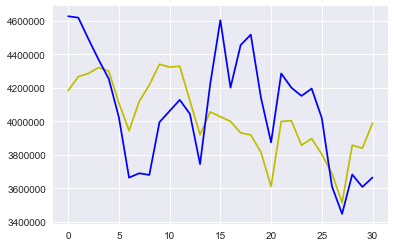

In [16]:
plt.plot(c2.pre[:31],color='y')
plt.plot(pd.DataFrame(Ytest.reset_index()['sum']),color='b')

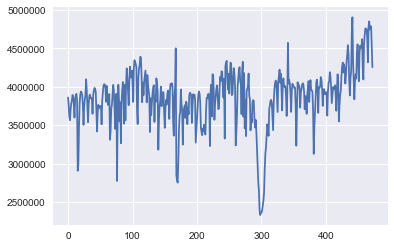

In [6]:
plt.plot(pd.DataFrame(rfr.predict(Xtrain)))

In [7]:
print(pd.DataFrame(rfr.predict(Xtrain)).shape)
Ytrain.shape

(473, 1)


(473, 1)

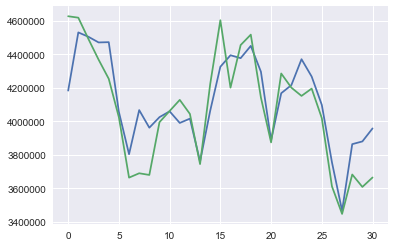

In [8]:
plt.plot(res)
plt.plot(pd.DataFrame(Ytest.reset_index()['sum']))

In [556]:
type(Y.index[1])

str

In [314]:
filename=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/'+numst+r'.xlsx'
print(filename)
c2[['date','pre']].to_excel(filename)

c:/users/lance/desktop/GitHub_project/tianchi_power_data/sum.xlsx


In [47]:
#晴，雨，阴，雪
weathers=pd.DataFrame(weatherdata.weather)

In [79]:
weathers=weathers.weather.apply(get_weather)

In [80]:
def get_weather(x):
    if '晴' in x:
        return '晴'
    elif '雨' in x:
        return '雨'
    elif '阴' in x:
        return '阴'
    elif '雪' in x:
        return '雪'
    elif '多云' in x:
        return '多云'

In [87]:
pd.get_dummies(weathers)

,多云,晴,阴,雨,雪
date,,,,,
2014-01-01,0,1,0,0,0
2014-01-02,1,0,0,0,0
2014-01-03,1,0,0,0,0
2014-01-04,1,0,0,0,0
2014-01-05,1,0,0,0,0
2014-01-06,0,0,1,0,0
2014-01-07,0,0,0,1,0
2014-01-08,0,0,1,0,0
2014-01-09,0,1,0,0,0


In [165]:
rfr.feature_importances_

array([ 0.03519944,  0.0843479 ,  0.07706372,  0.01307171,  0.23669057,
        0.1166893 ,  0.10463705,  0.11407458,  0.06855552,  0.0463311 ,
        0.03158907,  0.03102755,  0.01201349,  0.00362995,  0.00496112,
        0.00721502,  0.00729282,  0.00505808,  0.000552  ])

In [167]:
Xtest.columns

Index(['dow', 'doy', 'day', 'month', 'd-1', 'd-2', 'd-3', 'd-4', 'd_dif',
       'max', 'min', 'max-min', 'is_holiday', 'is_weekend', 'cloudy', 'sunny',
       'heavy', 'rain', 'snow'],
      dtype='object')